In [8]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Text(0.5, 1.0, 'Imagem Original')

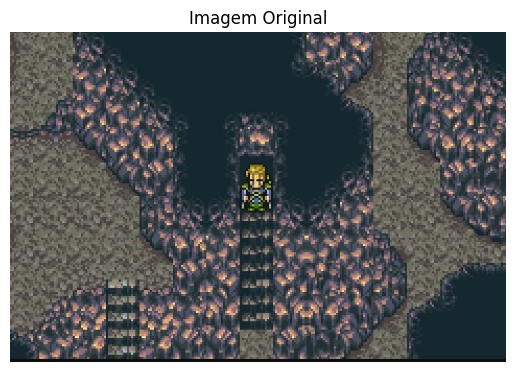

In [9]:
dicionario = {
    'Planicie': 'FFVI\\Maps\\planicie.jpg',
    'Planicie2': 'FFVI\\Maps\\planicie2.jpg',
    'Planicie3': 'FFVI\\Maps\\planicie3.jpg',
    'CavernaExt': 'FFVI\\Maps\\caverna_exterior.jpg',
    'CavernaInt': 'FFVI\\Maps\\caverna_interior.jpg',
}

escolha = 'CavernaInt' 
original_image = Image.open(dicionario[escolha])
cv2_img = np.array(original_image)
plt.imshow(cv2_img)
plt.axis('off')
plt.title('Imagem Original')

Text(0.5, 1.0, 'Imagem em Escala de Cinza')

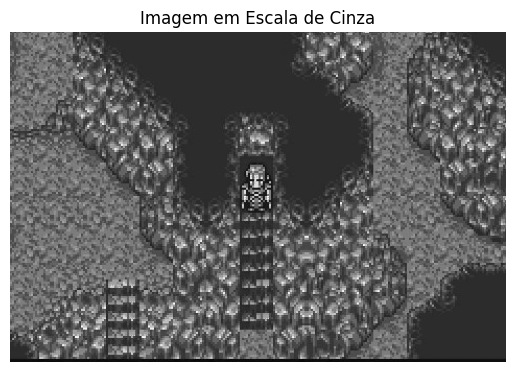

In [10]:
gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Imagem em Escala de Cinza')

Text(0.5, 1.0, 'Imagem Binária')

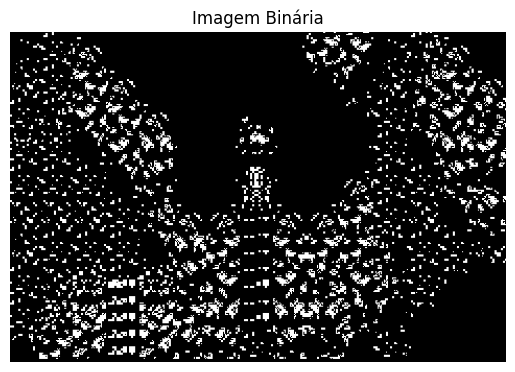

In [7]:
# da imagem em escala de cinza para binária tirar os pixels mais escuros
_, binaria = cv2.threshold(gray, 115, 255, cv2.THRESH_BINARY)
plt.figure()
plt.imshow(binaria, cmap='gray')
plt.axis('off')
plt.title('Imagem Binária')

Text(0.5, 1.0, 'Detecção de Bordas com Sobel')

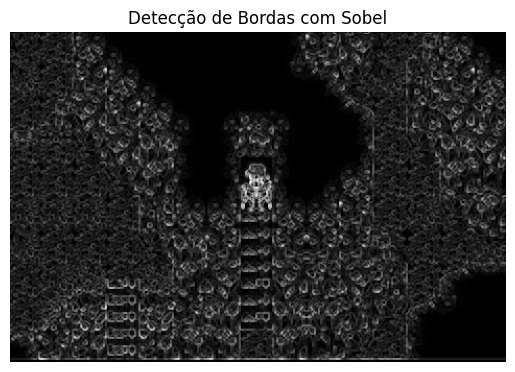

In [8]:
# Aplicar detecção de bordas usando o operador de Sobel
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = np.sqrt(sobel_x**2 + sobel_y**2)
plt.figure()
plt.imshow(sobel, cmap='gray')
plt.axis('off')
plt.title('Detecção de Bordas com Sobel')

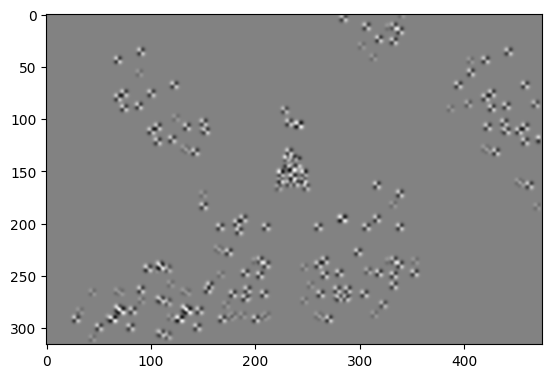

In [12]:
_, thresholded_image = cv2.threshold(gray, 180, 200, cv2.THRESH_BINARY)
edges = cv2.Sobel(thresholded_image, cv2.CV_64F, 1, 1, ksize=15)
edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
plt.imshow(edges, cmap = 'gray')

True

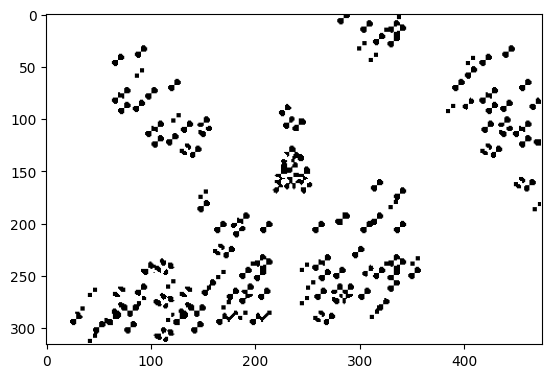

In [13]:
_, binary_image = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)
# Exibir a imagem binarizada
plt.imshow(binary_image, cmap='gray')
cv2.imwrite(f'results/{escolha}_edges.jpeg', binary_image)

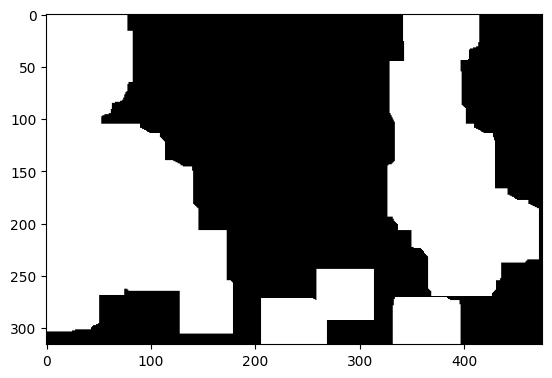

In [77]:
edges_closed = cv2.GaussianBlur(gray, (11, 11), 0)
edges_closed = cv2.GaussianBlur(edges_closed, (7, 7), 0)
edges_closed = cv2.GaussianBlur(edges_closed, (5, 5), 0)
edges_closed = cv2.GaussianBlur(edges_closed, (3, 3), 0)
_, thresholded_image = cv2.threshold(edges_closed, 90, 255, cv2.THRESH_BINARY)
kernel = np.ones((4,4), np.uint8)
edges_closed = cv2.erode(thresholded_image, kernel, iterations=4)
kernel = np.ones((5,5), np.uint8)
imagem_dilatada = cv2.dilate(edges_closed, kernel, iterations=12)
plt.imshow(imagem_dilatada, cmap='grey')

True

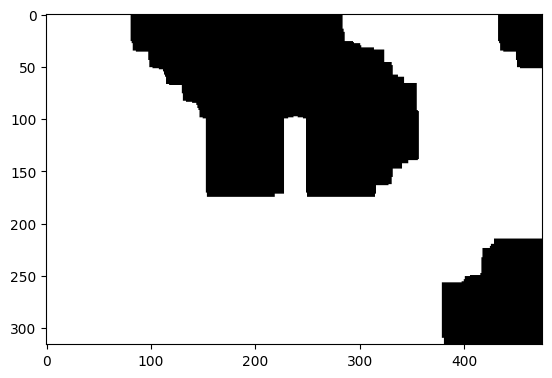

In [103]:
edges_closed = cv2.Canny(gray, 10, 1)
# Definir um kernel para operações de morfologia
kernel = np.ones((10,10), np.uint8)
# smoothed_image = cv2.GaussianBlur(edges_closed, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# Fechar as falhas nos traços
edges_closed = cv2.morphologyEx(edges_closed, cv2.MORPH_CLOSE, kernel)
# Erodir as linhas para reduzi-las de volta ao tamanho original ou próximo dele
edges_closed = cv2.erode(edges_closed, kernel, iterations=4)

edges_binary = cv2.threshold(edges_closed, 0, 255, cv2.THRESH_BINARY)[1]
plt.imshow(edges_binary, cmap='grey')
cv2.imwrite(f'results/{escolha}_contorno.jpeg', edges_binary)

Text(0.5, 1.0, 'Contorno da Imagem Original')

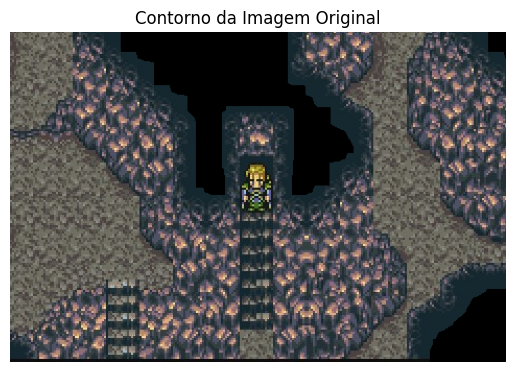

In [76]:
# Agora colocar o contorno na imagem original
contorno = cv2.bitwise_and(cv2_img, cv2_img, mask=imagem_dilatada)
plt.figure()
plt.imshow(contorno)
plt.axis('off')
plt.title('Contorno da Imagem Original')

Text(0.5, 1.0, 'Contorno da Imagem Original')

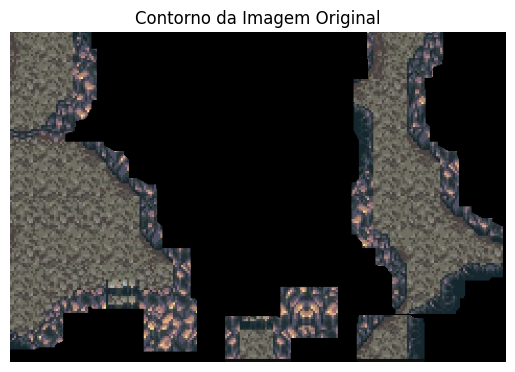

In [78]:
edges_closed = cv2.GaussianBlur(gray, (11, 11), 0)
edges_closed = cv2.GaussianBlur(edges_closed, (7, 7), 0)
edges_closed = cv2.GaussianBlur(edges_closed, (5, 5), 0)
edges_closed = cv2.GaussianBlur(edges_closed, (3, 3), 0)
_, thresholded_image = cv2.threshold(edges_closed, 90, 255, cv2.THRESH_BINARY)
kernel = np.ones((4,4), np.uint8)
edges_closed = cv2.erode(thresholded_image, kernel, iterations=4)
kernel = np.ones((5,5), np.uint8)
imagem_dilatada = cv2.dilate(edges_closed, kernel, iterations=12)
contorno = cv2.bitwise_and(cv2_img, cv2_img, mask=imagem_dilatada)
plt.figure()
plt.imshow(contorno)
plt.axis('off')
plt.title('Contorno da Imagem Original')